In [ ]:
# Flower recognization using CNN
# Author: Debabrata Ghorai
# This tutorial shows how to identify/classify flowers from images
# It creates an image classifier using keras sequential model
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# create a folder and unzip files (optional)
!tar xfz "/content/drive/My Drive/Datasets/flower_photos.tgz" -C "/content/drive/My Drive/Datasets/flower_photos_unzip"

In [ ]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
# test gpu
import tensorflow
tensorflow.test.gpu_device_name()

''

In [ ]:
# reading the flower dataset
# main directory of the flower dataset
path = r"/content/drive/My Drive/Datasets/flower_photos_unzip/flower_photos"

# each flower species containing into a seperate sub-folder
# get list of all flower data paths from all the sub-directory
filelist = []
for root, dirs, files in os.walk(path):
    for fname in files:
        if fname.endswith(".jpg"):
            fpath = os.path.join(root, fname)
            filelist.append(fpath)

In [ ]:
# build a dataframe with image full-path and category/flower name
df = pd.DataFrame(filelist, columns=["image"])
# append flower name
for ix, row in df.iterrows():
    flower_name = row['image'].split("/")[-2]
    df.loc[ix, 'name'] = flower_name

In [ ]:
# get dataset's basic stats
tot_sample = df.shape[0]
print("Total flowers image count in dataset: ", tot_sample)
flowers_counts = df['name'].value_counts()
flowers = flowers_counts.keys().tolist()
print("Flowers names: ", flowers)
for flower in flowers:
    print(flower+' total count: '+str(flowers_counts[flower]))


Total flowers image count in dataset:  3670
Flowers names:  ['dandelion', 'tulips', 'sunflowers', 'roses', 'daisy']
dandelion total count: 898
tulips total count: 799
sunflowers total count: 699
roses total count: 641
daisy total count: 633


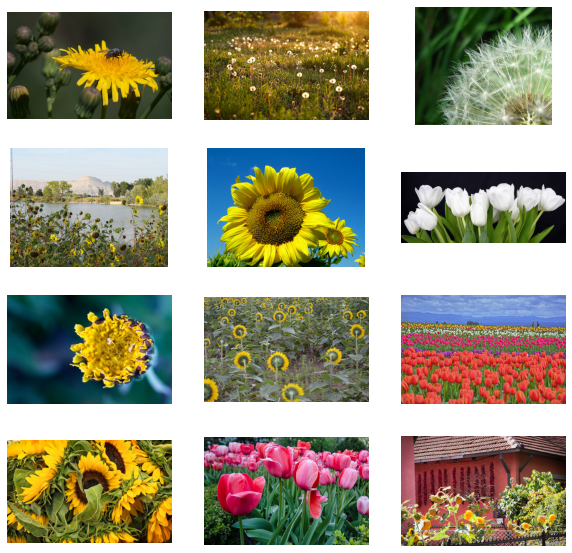

In [ ]:
# plot some sample images
sample_files = random.sample(filelist, 12)
f, ax = plt.subplots(4, 3, figsize=(10, 10))
for i, f in enumerate(sample_files):
    image = plt.imread(f)
    ax[i//3, i%3].imshow(image)
    ax[i//3, i%3].axis('off')
plt.show()

In [ ]:
# create label of the images
labels = {}
for i, flower in enumerate(flowers):
    labels[flower] = i

# add label column to df
for ix, row in df.iterrows():
    df.loc[ix, 'label'] = labels[row['name']]
    
# train-test split
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42)


In [ ]:
# resize image and list all of them
def prepare_data(x_train, y_train, h=150, w=150):
  x_lists = []
  y_lists = []
  for i, j in zip(x_train, y_train):
    img = cv2.imread(i)
    img_resize = cv2.resize(img, (w, h))
    img_tf = img_resize.reshape((1,)+img_resize.shape)
    x_lists.append(img_tf)
    y_lists.append(int(j))
  return x_lists, y_lists

In [ ]:
# prepare model train/validation datasets
x_lists, y_lists = prepare_data(x_train_t, y_train_t)

In [ ]:
X_train_arr = np.concatenate(x_lists)/255.0
y_train_arr = to_categorical(y_lists)
X_train, X_val, y_train, y_val = train_test_split(X_train_arr, y_train_arr, test_size=0.2, random_state=42)

In [ ]:
# sequential model inputs
_, height, width, channel = X_train.shape
outnode = len(labels)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# build keras sequential model for flower recognization/classification
def build_model():
  # build model
  model = keras.Sequential()
  # learn a total of 32 filters, kernel size 3x3
  model.add(layers.Conv2D(32, (3, 3), input_shape=(height, width, channel), padding="Same", activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #  learn a total of 64 filters, kernel size 3x3
  model.add(layers.Conv2D(64, (3, 3), padding="Same", activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #  learn a total of 100 filters, kernel size 3x3
  model.add(layers.Conv2D(100, (3, 3), padding="Same", activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  #  learn a total of 112 filters, kernel size 3x3
  model.add(layers.Conv2D(112, (3, 3), padding="Same", activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # flatten the 3D output to 1D
  model.add(layers.Flatten())
  # add dense layer
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  # add output layer
  model.add(layers.Dense(outnode, activation='softmax'))
  return model

In [ ]:
# compile model and check model summary
opt = keras.optimizers.Adam(learning_rate=0.001)
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 100)       57700     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 100)      0

In [ ]:
# training data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range = 10,
    shear_range = 0.2,
    zoom_range = 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    vertical_flip=False,
    brightness_range = (0.5, 1.5)
    )
# fit the training data
datagen.fit(X_train)

In [ ]:
mcp = ModelCheckpoint(filepath='/content/drive/My Drive/Datasets/flower_photos_unzip/cnn_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
es = EarlyStopping(monitor='val_loss', patience=7)
callbacks = [es, mcp]

In [ ]:
# train the model with 20% validation split
batch_size = 128
history = model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
    callbacks=callbacks
    )

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.5022 - accuracy: 0.3246
Epoch 1: val_loss improved from inf to 1.30623, saving model to /content/drive/My Drive/Datasets/flower_photos_unzip/cnn_model_3.h5
17/17 [==============================] - 119s 7s/step - loss: 1.5022 - accuracy: 0.3246 - val_loss: 1.3062 - val_accuracy: 0.4339
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.2103 - accuracy: 0.4710
Epoch 2: val_loss improved from 1.30623 to 1.15156, saving model to /content/drive/My Drive/Datasets/flower_photos_unzip/cnn_model_3.h5
17/17 [==============================] - 105s 6s/step - loss: 1.2103 - accuracy: 0.4710 - val_loss: 1.1516 - val_accuracy: 0.5175
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.1044 - accuracy: 0.5358
Epoch 3: val_loss improved from 1.15156 to 1.14992, saving model to /content/drive/My Drive/Datasets/flower_photos_unzip/cnn_model_3.h5
17/17 [==============================] - 104s 6s/step 

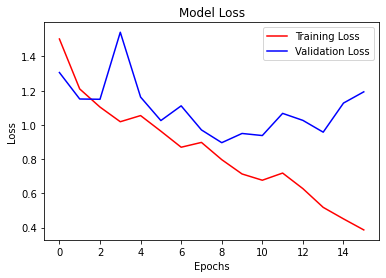

In [ ]:
# plot model loss
plt.plot(history.history['loss'], "r", label='Training Loss')
plt.plot(history.history['val_loss'], "b", label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

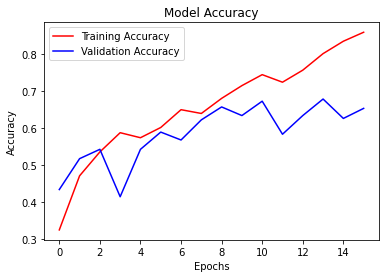

In [ ]:
# plot model accuracy
plt.plot(history.history['accuracy'], "r", label='Training Accuracy')
plt.plot(history.history['val_accuracy'],"b", label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Load and evaluate the best model version
x_test_lists, y_true = prepare_data(x_test_t, y_test_t)
X_test = np.concatenate(x_test_lists)/255.0

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Datasets/flower_photos_unzip/cnn_model.h5')
y_pred = model.predict(X_test)
y_pred2 = np.argmax(y_pred, axis=1)
# print accuracy score
print(round(accuracy_score(y_true, y_pred2), 2))

0.66


In [ ]:
# References
# https://www.tensorflow.org/hub/tutorials/image_feature_vector
# https://github.com/Ishasharmax/FlowerClassificationCNN/blob/main/flowerClassification.ipynb
# https://towardsdatascience.com/keras-callbacks-and-how-to-save-your-model-from-overtraining-244fc1de8608
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://towardsdatascience.com/build-train-and-deploy-a-real-world-flower-classifier-of-102-flower-types-a90f66d2092a
# https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/